In [1]:
%load_ext autoreload
%autoreload 2
import xarray as xr
from pathlib import Path
from hmpai.pytorch.models import *
from hmpai.training import split_data_on_participants
from hmpai.pytorch.training import train, validate, calculate_class_weights, train_and_test, k_fold_cross_validate, test
from hmpai.pytorch.utilities import DEVICE, set_global_seed, get_summary_str, save_model, load_model
from hmpai.pytorch.generators import SAT1Dataset
from hmpai.data import SAT1_STAGES_ACCURACY
from hmpai.visualization import plot_confusion_matrix
from hmpai.normalization import *
from torchinfo import summary
from hmpai.utilities import print_results, CHANNELS_2D, AR_SAT1_CHANNELS
from torch.utils.data import DataLoader
from mne.io import read_info

In [2]:
set_global_seed(42)
# data_path = Path("../data/sat1/split_stage_data.nc")
data_path = Path("../data/sat1/split_stage_data_100hz.nc")
# data_path = Path("../data/sat1/split_stage_data_unprocessed_500hz.nc")

dataset = xr.load_dataset(data_path)

In [3]:
shape_topological = False
train_data, val_data, test_data = split_data_on_participants(
    dataset, 60, norm_min1_to_1
)
train_acc = train_data.where(train_data.cue == "AC", drop=True)
train_sp = train_data.where(train_data.cue == "SP", drop=True)
val_acc = val_data.where(val_data.cue == "AC", drop=True)
val_sp = val_data.where(val_data.cue == "SP", drop=True)
test_acc = test_data.where(test_data.cue == "AC", drop=True)
test_sp = test_data.where(test_data.cue == "SP", drop=True)

In [4]:
train_dataset = SAT1Dataset(train_acc, shape_topological=shape_topological)
val_dataset = SAT1Dataset(val_acc, shape_topological=shape_topological)
test_dataset = SAT1Dataset(test_acc, shape_topological=shape_topological)
test_sp = SAT1Dataset(test_sp, shape_topological=shape_topological)


In [5]:
model = SAT1GRU(
    len(train_data.channels), len(train_data.samples), len(train_data.labels)
)

train_and_test(
    model,
    train_dataset,
    test_dataset,
    val_dataset,
    logs_path=Path("../logs/"),
    workers=4,
    batch_size=128,
    labels=SAT1_STAGES_ACCURACY
)

/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/54 [00:00<?, ? batch/s]

  0%|          | 0/54 [00:00<?, ? batch/s]

  0%|          | 0/54 [00:00<?, ? batch/s]

  0%|          | 0/54 [00:00<?, ? batch/s]

  0%|          | 0/54 [00:00<?, ? batch/s]

  0%|          | 0/54 [00:00<?, ? batch/s]

  0%|          | 0/54 [00:00<?, ? batch/s]

  0%|          | 0/54 [00:00<?, ? batch/s]

  0%|          | 0/54 [00:00<?, ? batch/s]

  0%|          | 0/54 [00:00<?, ? batch/s]

  0%|          | 0/54 [00:00<?, ? batch/s]

  0%|          | 0/54 [00:00<?, ? batch/s]

  0%|          | 0/54 [00:00<?, ? batch/s]

  0%|          | 0/54 [00:00<?, ? batch/s]

  0%|          | 0/54 [00:00<?, ? batch/s]

  0%|          | 0/54 [00:00<?, ? batch/s]

  0%|          | 0/54 [00:00<?, ? batch/s]

  0%|          | 0/54 [00:00<?, ? batch/s]

  0%|          | 0/54 [00:00<?, ? batch/s]

  0%|          | 0/54 [00:00<?, ? batch/s]

{'0': {'precision': 0.7957244655581948,
  'recall': 0.7362637362637363,
  'f1-score': 0.7648401826484018,
  'support': 455.0},
 '1': {'precision': 0.8823529411764706,
  'recall': 0.8842794759825328,
  'f1-score': 0.8833151581243184,
  'support': 458.0},
 '2': {'precision': 0.9196428571428571,
  'recall': 0.8995633187772926,
  'f1-score': 0.9094922737306843,
  'support': 458.0},
 '3': {'precision': 0.9608294930875576,
  'recall': 0.9104803493449781,
  'f1-score': 0.9349775784753362,
  'support': 458.0},
 '4': {'precision': 0.8133333333333334,
  'recall': 0.9323144104803494,
  'f1-score': 0.868769074262462,
  'support': 458.0},
 'accuracy': 0.8727590730214254,
 'macro avg': {'precision': 0.8743766180596827,
  'recall': 0.8725802581697778,
  'f1-score': 0.8722788534482406,
  'support': 2287.0},
 'weighted avg': {'precision': 0.8744797909750761,
  'recall': 0.8727590730214254,
  'f1-score': 0.8724197874283015,
  'support': 2287.0}}

In [6]:
test_loader = DataLoader(
    test_dataset, 128, shuffle=True, num_workers=4, pin_memory=True
)
results, pred, true = test(model, test_loader, None)
pred = pred.cpu()

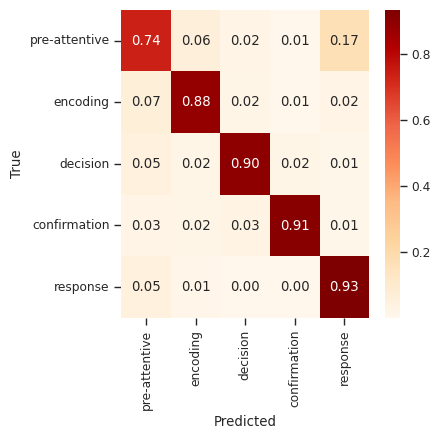

In [7]:
# On test set (Condition accuracy)
plot_confusion_matrix(true, pred, SAT1_STAGES_ACCURACY, save=True)

In [8]:
test_loader = DataLoader(
    test_sp, 128, shuffle=True, num_workers=4, pin_memory=True
)
results, pred, true = test(model, test_loader, None)
pred = pred.cpu()

/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

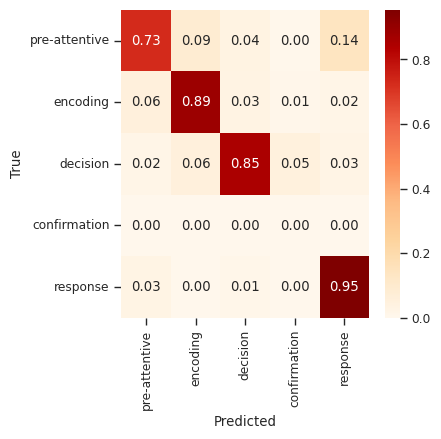

In [9]:
# On test set (Condition speed)
plot_confusion_matrix(true, pred, SAT1_STAGES_ACCURACY, save=True)